In [4]:
import os

In [5]:
train_data_path = '/home/mbarin/Desktop/binary-vae/binary-data/'

In [6]:
import glob
import numpy as np

import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from data_utils import to_rgb
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import json

In [62]:
class BEVDataset(Dataset):
    def __init__(self, data_path, split):
        self.data_path = data_path
        self.npz_file_name = 'bev' if split != 'test' else 'arr_0'
        self.image_folder = 'bev_binary_npz' if split != 'test' else 'bev_pro'
        self.cmd_folder = 'measurements'
        self.images, self.cmds = self.prepare_data()
        self.transform = transforms.Compose([   transforms.ToTensor(),
                                                transforms.CenterCrop(192),
                                                
                                                ]) 

        self.class_statistics = {'vehicles':{}}                                                


    def prepare_data(self):
        main_folders = sorted(os.listdir(self.data_path))
        sub_folders = []
        for folder in main_folders:
            sub_folders_path = self.data_path + folder
            sub_folders += glob.glob(sub_folders_path)
        
        images = []
        cmds = []
        for folder in sub_folders:
            img_paths = folder + '/' + self.image_folder + '/*'
            img_paths = sorted(glob.glob(img_paths))
            images.extend(img_paths)
            
            cmd_paths = folder + '/' + self.cmd_folder + '/*'
            cmd_paths = sorted(glob.glob(cmd_paths))
            cmds.extend(cmd_paths)

        return [images[:6]], [cmds[:6]]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_paths = self.images[idx]
        cmd_paths = self.cmds[idx]
        #print(cmd_path)
        
        bevs = torch.zeros((6,8,192,192))
        bevs_orig = torch.zeros((6,8,192,192))
        cmds = torch.zeros((6,4,4))
        for i,img_path in enumerate(img_paths):
            bev = np.load(img_path).get(self.npz_file_name)
            if bev.shape[2] == 9:
                bev = np.transpose(bev,(2,0,1)) # make channel dim first

            bev_orig = np.delete(bev, 2, axis=0)
            bev = np.transpose(bev_orig,(1,2,0))
            #bevs_orig[i] = torch.Tensor(bev)
            bevs[i] = self.transform(bev)
            with open(cmd_paths[i],) as f: 
                cmds[i] = torch.Tensor(json.load(f)['ego_matrix'])

        

        return bevs, cmds

In [19]:
def visualize(img):
    return to_rgb(img)

In [63]:
train_data = BEVDataset(train_data_path,split='train')
train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True)

In [64]:
bev, cmd = next(iter(train_dataloader))

In [33]:
def pose_vec2mat(vec: torch.Tensor):
    """
    Convert 6DoF parameters to transformation matrix.
    Args:
        vec: 6DoF parameters in the order of tx, ty, tz, rx, ry, rz [B,6]
    Returns:
        A transformation matrix [B,4,4]
    """
    translation = vec[..., :3].unsqueeze(-1)  # [...x3x1]
    rot = vec[..., 3:].contiguous()  # [...x3]
    rot_mat = euler2mat(rot)  # [...,3,3]
    transform_mat = torch.cat([rot_mat, translation], dim=-1)  # [...,3,4]
    transform_mat = torch.nn.functional.pad(transform_mat, [0, 0, 0, 1], value=0)  # [...,4,4]
    transform_mat[..., 3, 3] = 1.0
    return transform_mat

In [48]:
def warp_features(x, flow, mode='nearest', spatial_extent=None):
    """ Applies a rotation and translation to feature map x.
        Args:
            x: (b, c, h, w) feature map
            flow: (b, 6) 6DoF vector (only uses the xy poriton)
            mode: use 'nearest' when dealing with categorical inputs
        Returns:
            in plane transformed feature map
        """
    if flow is None:
        return x
    b, c, h, w = x.shape
    # z-rotation
    angle = flow[:, 5].clone()  # torch.atan2(flow[:, 1, 0], flow[:, 0, 0])
    # x-y translation
    translation = flow[:, :2].clone()  # flow[:, :2, 3]

    # Normalise translation. Need to divide by how many meters is half of the image.
    # because translation of 1.0 correspond to translation of half of the image.
    translation[:, 0] /= 1 #spatial_extent[0]
    translation[:, 1] /= 1 #spatial_extent[1]
    # forward axis is inverted
    translation[:, 0] *= -1

    cos_theta = torch.cos(angle)
    sin_theta = torch.sin(angle)

    # output = Rot.input + translation
    # tx and ty are inverted as is the case when going from real coordinates to numpy coordinates
    # translation_pos_0 -> positive value makes the image move to the left
    # translation_pos_1 -> positive value makes the image move to the top
    # Angle -> positive value in rad makes the image move in the trigonometric way
    transformation = torch.stack([cos_theta, -sin_theta, translation[:, 1],
                                  sin_theta, cos_theta, translation[:, 0]], dim=-1).view(b, 2, 3)

    # Note that a rotation will preserve distances only if height = width. Otherwise there's
    # resizing going on. e.g. rotation of pi/2 of a 100x200 image will make what's in the center of the image
    # elongated.
    grid = torch.nn.functional.affine_grid(transformation, size=x.shape, align_corners=False)
    warped_x = torch.nn.functional.grid_sample(x, grid.float(), mode=mode, padding_mode='zeros', align_corners=False)

    return warped_x

In [35]:
def mat2pose_vec(matrix: torch.Tensor):
    """
    Converts a 4x4 pose matrix into a 6-dof pose vector
    Args:
        matrix (ndarray): 4x4 pose matrix
    Returns:
        vector (ndarray): 6-dof pose vector comprising translation components (tx, ty, tz) and
        rotation components (rx, ry, rz)
    """

    # M[1, 2] = -sinx*cosy, M[2, 2] = +cosx*cosy
    rotx = torch.atan2(-matrix[..., 1, 2], matrix[..., 2, 2])

    # M[0, 2] = +siny, M[1, 2] = -sinx*cosy, M[2, 2] = +cosx*cosy
    cosy = torch.sqrt(matrix[..., 1, 2] ** 2 + matrix[..., 2, 2] ** 2)
    roty = torch.atan2(matrix[..., 0, 2], cosy)

    # M[0, 0] = +cosy*cosz, M[0, 1] = -cosy*sinz
    rotz = torch.atan2(-matrix[..., 0, 1], matrix[..., 0, 0])

    rotation = torch.stack((rotx, roty, rotz), dim=-1)

    # Extract translation params
    translation = matrix[..., :3, 3]
    return torch.cat((translation, rotation), dim=-1)

In [49]:
def cumulative_warp_features(x, flow, mode='nearest', spatial_extent=None):
    """ Warps a sequence of feature maps by accumulating incremental 2d flow.
    x[:, -1] remains unchanged
    x[:, -2] is warped using flow[:, -2]
    x[:, -3] is warped using flow[:, -3] @ flow[:, -2]
    ...
    x[:, 0] is warped using flow[:, 0] @ ... @ flow[:, -3] @ flow[:, -2]
    Args:
        x: (b, t, c, h, w) sequence of feature maps
        flow: (b, t, 6) sequence of 6 DoF pose  xxxxx flow --> matrix
            from t to t+1 (only uses the xy poriton)
    """
    sequence_length = x.shape[1]
    if sequence_length == 1:
        return x
    print('X ', x.shape)
    print('FLOW ', flow.shape)
    #flow = pose_vec2mat(flow)
    
    #flow = flow.view(-1,4,4)  # b,t,4,4
    print('FLOW ', flow.shape)

    out = [x[:, -1]]
    cum_flow = flow[:, -2]
    
    print('out ', out[0].shape)
    print('cum flow ', cum_flow.shape)
    
    for t in reversed(range(sequence_length - 1)):
        out.append(warp_features(x[:, t], mat2pose_vec(cum_flow), mode=mode, spatial_extent=spatial_extent))
        # @ is the equivalent of torch.bmm
        cum_flow = flow[:, t - 1] @ cum_flow

    return torch.stack(out[::-1], 1)

In [50]:
warped = cumulative_warp_features(bev,torch.Tensor(cmd))

X  torch.Size([1, 6, 8, 192, 192])
FLOW  torch.Size([1, 6, 4, 4])
FLOW  torch.Size([1, 6, 4, 4])
out  torch.Size([1, 8, 192, 192])
cum flow  torch.Size([1, 4, 4])


In [51]:
warped.shape

torch.Size([1, 6, 8, 192, 192])

In [24]:
torch.Tensor(cmd).shape

torch.Size([4, 4])

torch.Size([8, 192, 192])
torch.Size([8, 192, 192])
torch.Size([8, 192, 192])
torch.Size([8, 192, 192])
torch.Size([8, 192, 192])
torch.Size([8, 192, 192])


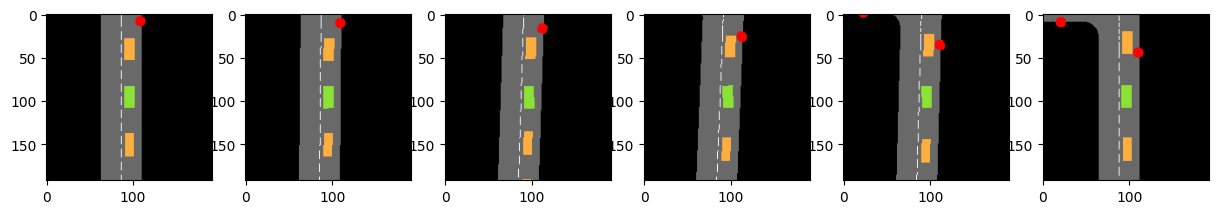

In [74]:
fig, axs = plt.subplots(1,6,figsize=(15, 15))


for i, b in enumerate(bev[0]):
    print(b.shape)
    bev_rgb_ = torch.permute(visualize(b),(1,2,0))  / 255

    axs[i].imshow(bev_rgb_)
            
plt.show() 
#plt.imsave(fig,"data_exploration/original_bevs.png")

torch.Size([8, 192, 192])
torch.Size([8, 192, 192])
torch.Size([8, 192, 192])
torch.Size([8, 192, 192])
torch.Size([8, 192, 192])
torch.Size([8, 192, 192])


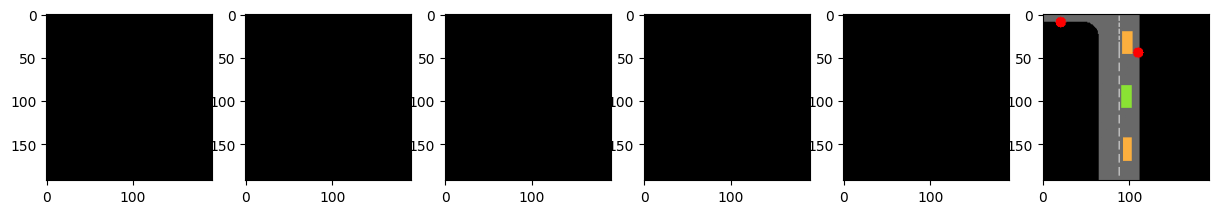

In [75]:
fig, axs = plt.subplots(1,6,figsize=(15, 15))


for i, b in enumerate(warped[0]):
    print(b.shape)
    bev_rgb_ = torch.permute(visualize(b),(1,2,0))  / 255

    axs[i].imshow(bev_rgb_)
            
plt.show() 